In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime as dt
import jdatetime as jd
from loguru import logger

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
#np.random.seed(0)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')

In [69]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0)

In [4]:
# def summary(df):
#     display(df.describe())
#     pass

keys = ['dtype','pct_of_nan', 'num_uniques']+list(revenue.describe().T.columns)[:-1]
print(f'Data shape: {revenue.shape}')
pd.concat([revenue.dtypes, 
          (revenue.isna().sum() / revenue.shape[0] * 100).map('% {:,.2f}'.format),
          revenue.nunique(),
          revenue.describe().T], axis=1, keys=keys)

Data shape: (261960, 4)


dtype pct_of_nan num_uniques  count                            \
                0          1           2  count     mean     std      min   
CustomerID  int64     % 0.00      179680 261960  7169337 4957141   465132   
OrderID     int64     % 0.00      261960 261960 45264897 6121027 32930756   
Date        int64     % 0.00         396 261960 20193661    4238 20190321   
Revenue     int64     % 0.00        3314 261960     6110    5647      106   

                                                
                25%      50%      75%      max  
CustomerID  3267469  6663396 11227062 46549548  
OrderID    40061748 44792436 50045929 58853188  
Date       20190821 20191109 20200115 20200419  
Revenue        2451     5100     7960   175200

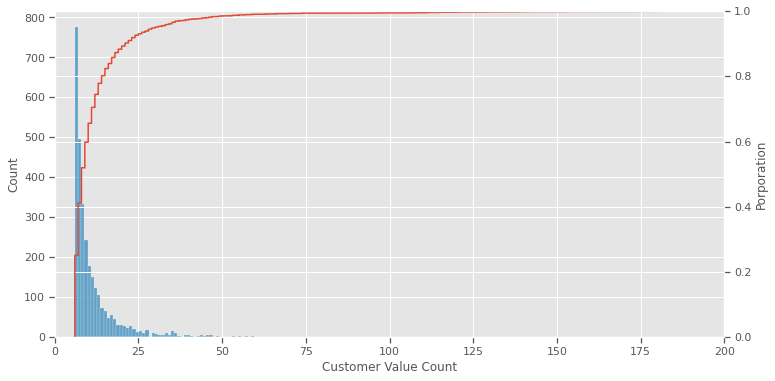

In [20]:
fig, ax1 = plt.subplots()
# ax1.set_title('Average Percipitation Percentage by Month')
ax1.set_xlabel('Customer Value Count')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,200)
ax2.set_xlim(0,200)
plt.show()

In [70]:
jd.set_locale('fa_IR')

'fa_IR'

In [26]:
jd.datetime.now()

            

jdatetime.datetime(1401, 1, 20, 19, 42, 38, 789679)

In [30]:

# jdatetime.date.fromgregorian(day=X,month=X,year=X)
jd.date.fromgregorian(date=dt.datetime.now())
# jdatetime.datetime.fromgregorian(datetime=datetime.datetime)

jdatetime.date(1401, 1, 20)

In [37]:
for index, row in revenue.iterrows():
    assert len(str(row['Date'])) == 8




In [71]:
for index, row in revenue.iterrows():
    revenue.loc[index, 'JdDate'] = jd.date.fromgregorian(date=dt.datetime.strptime(str(row['Date']), '%Y%m%d'))
    revenue.loc[index, 'Date'] = dt.datetime.strptime(str(row['Date']), '%Y%m%d')


AttributeError: 'datetime.datetime' object has no attribute 'data'

In [67]:
revenue.Date[0:1].dt.strftime()

AttributeError: Can only use .dt accessor with datetimelike values